## What’s the relationship between length of stay and survival rate?

EDA: JointGrid with a regplot for the linear regression model and a distplot for the distribution. The model would predict survival rate given length of stay. The ADMISSIONS data would be segmented by length of stay and whether the patient died at the hospital. Visualization: Seaborn. 

In [1]:
# Imports for DFs & connecting to Postgres
import pandas as pd
import psycopg2

### Pull in Admissions data
- Shape is (58976, 19)
- Columns are 'row_id','subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data

In [2]:
# Connect to Postgres & get all records for ADMISSIONS
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT * FROM mimiciii.admissions;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)  

OK


In [3]:
# Store ADMISSIONS result in var
admissions_all = cur.fetchall()

In [4]:
# Convert ADMISSIONS result to DF
admissions_df = pd.DataFrame(admissions_all, columns = ['row_id','subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
 'admission_type', 'admission_location', 'discharge_location',
 'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
 'has_chartevents_data'])

In [5]:
# Create shortened DF of relevant cols; 'hospital_expire_flag' represents whether patient died at hospital during given admission
admission_short = admissions_df[['subject_id', 'hadm_id', 'admission_type', 'hospital_expire_flag']]

### Pull in ICUSTAY data
- Shape is (61532, 12)
- Columns are 'row_id', 'subject_id', 'hadm_id', 'icustay_id', 'dbsource', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime', 'los'

In [6]:
# Connect to Postgres & get all records for ICUSTAYS
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT * FROM mimiciii.icustays;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)  

OK


In [7]:
# Store ICUSTAYS result in var
icustays_all = cur.fetchall()

In [8]:
# Convert ICUSTAYS result to DF
icustays_df = pd.DataFrame(icustays_all, columns = ['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'dbsource', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime', 'los'])

In [9]:
# Create shortened DF of relevant cols; 'los' represents fractional days e.g. 2.0922 = 2 days, 2 hours, 12 minutes, & 46 seconds
icu_short = icustays_df[['subject_id', 'hadm_id', 'icustay_id', 'los']]

In [10]:
# Create merged DF, left join of admission_short to icu_short
icu_adm_short = icu_short.merge(admission_short, how='left', on='hadm_id', suffixes=('_icu', '_adm'))

In [11]:
# Group DF by admission, sum the length of stay in ICU, and capture whether patient died in hospital during the admission
icu_adm_los = icu_adm_short.groupby('hadm_id').agg({'los':'sum','hospital_expire_flag':'max'})

In [12]:
# Imports for generating plot
import seaborn as sns
from scipy import stats

C:\Users\bcrom\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\bcrom\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


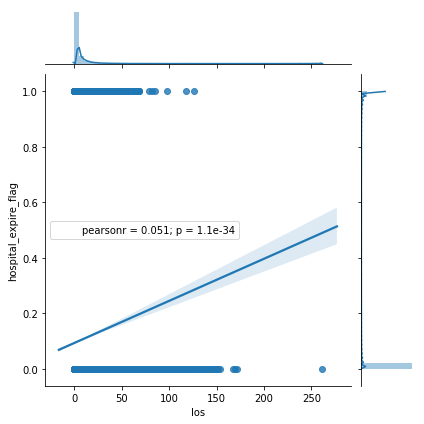

In [13]:
# Generate plot showing linear regression of 'hospital_expire_flag' given 'los' & the underlying distribution
h = sns.JointGrid(data=icu_adm_los, x='los', y='hospital_expire_flag')
h = h.plot(sns.regplot, sns.distplot)
h = h.annotate(stats.pearsonr)

## Interpretation

**Based on the results above we can see the Pearson's Correlation Coefficient is weak at only 0.051 or 5.1%. This means there is a weak relationship between the cumulative length of stay in the ICU and dying in the hospital during a given admission. We can also see the p-value is extremely small at 1.1e-34. This means the results, while weak, are statistically significant. Our implied null hypothesis here is there's no relationship between cumulative length of stay in the ICU and a patient dying in the hospital during that admission. Given the results above we can reliably reject the null hypothesis. There does appear to be a weak relationship between length of stay and dying in the hospital during a given admission.**